In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz")
raw_data = pd.read_csv(url, header=None)
raw_data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
raw_data.shape

(581012, 55)

In [4]:
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]

soil_type = raw_data.loc[:, 14:53].apply(
    lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)
wilderness_area = raw_data.loc[:, 10:13].apply(
    lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)

CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

data = pd.concat(
    [raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]],
    axis=1,
    
    ignore_index=True,
)
data.columns = CSV_HEADER
data["Cover_Type"] = data["Cover_Type"] - 1
data.head().T

,0,1,2,3,4
Elevation,2596,2590,2804,2785,2595
Aspect,51,56,139,155,45
Slope,3,2,9,18,2
Horizontal_Distance_To_Hydrology,258,212,268,242,153
Vertical_Distance_To_Hydrology,0,-6,65,118,-1
Horizontal_Distance_To_Roadways,510,390,3180,3090,391
Hillshade_9am,221,220,234,238,220
Hillshade_Noon,232,235,238,238,234
Hillshade_3pm,148,151,135,122,150
Horizontal_Distance_To_Fire_Points,6279,6225,6121,6211,6172


In [5]:
data.shape

(581012, 13)

In [6]:
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

In [10]:
print(train_data.shape)
print(test_data.shape)

(493620, 13)
(87392, 13)


In [11]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

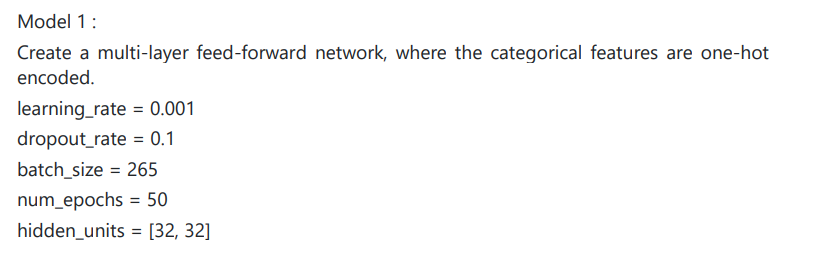

In [12]:
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [13]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

In [14]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [15]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [16]:
from tensorflow.keras.layers import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )
            if use_embedding:
                
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
               
                encoded_feature = embedding(encoded_feature)
            else:
               
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


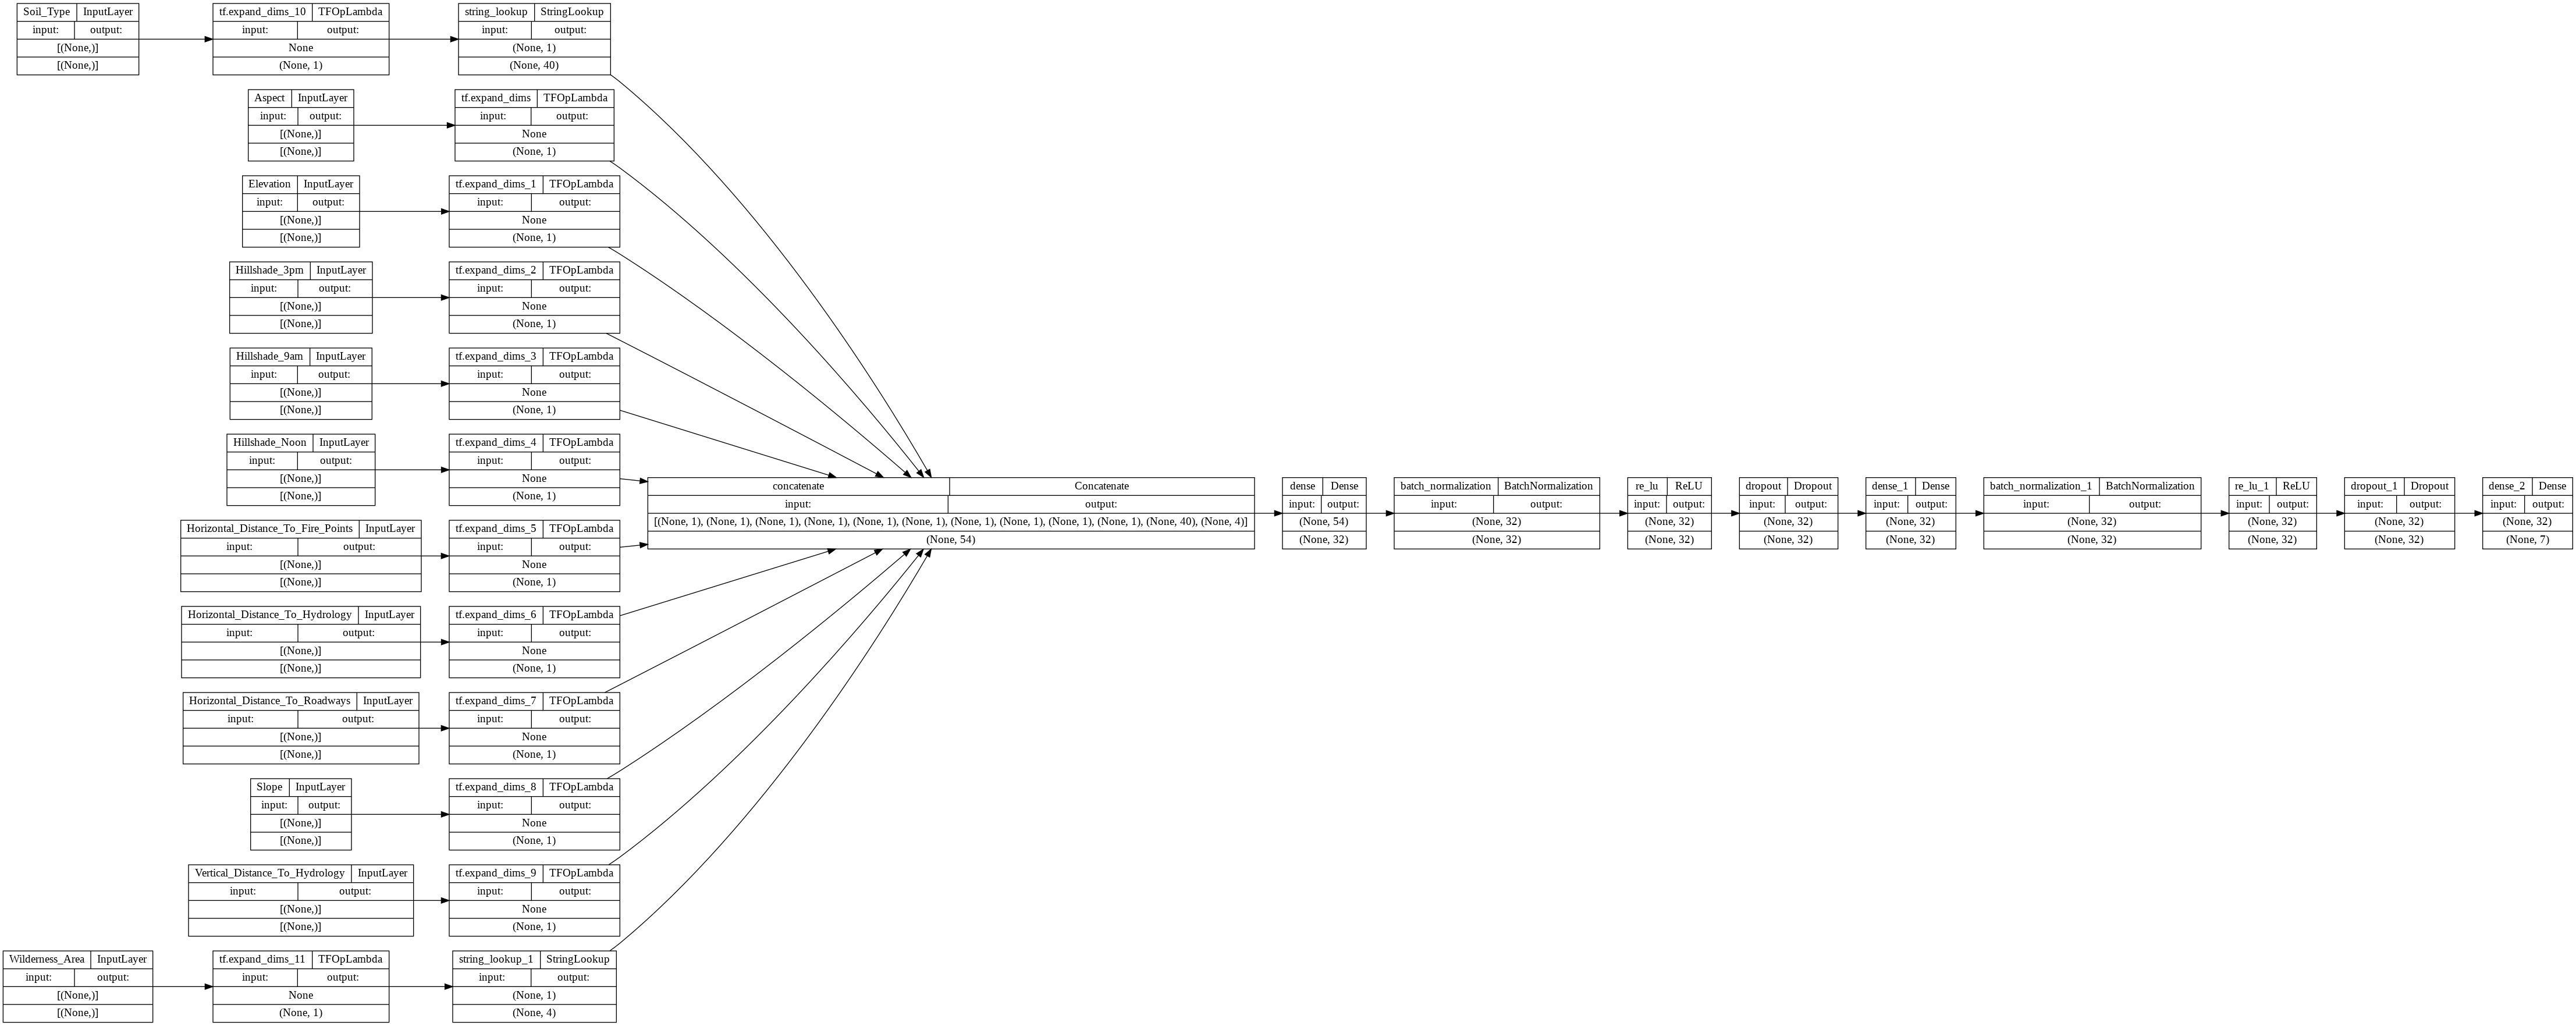

In [17]:
from tensorflow.keras import layers
from tensorflow import keras

def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [18]:
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
1863/1863 [==============================] - 18s 8ms/step - loss: 0.7644 - sparse_categorical_accuracy: 0.6813
Epoch 2/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.6659 - sparse_categorical_accuracy: 0.7139
Epoch 3/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.6395 - sparse_categorical_accuracy: 0.7240
Epoch 4/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.6218 - sparse_categorical_accuracy: 0.7312
Epoch 5/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.6099 - sparse_categorical_accuracy: 0.7368
Epoch 6/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.6009 - sparse_categorical_accuracy: 0.7418
Epoch 7/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.5943 - sparse_categorical_accuracy: 0.7437
Epoch 8/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.5885 - sparse_categorical_accuracy: 0.7468
Epo

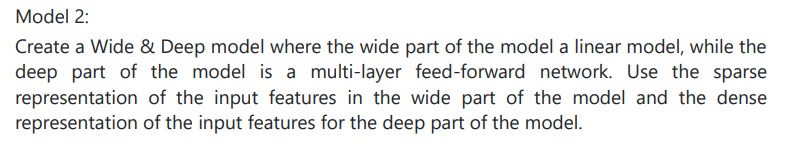

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


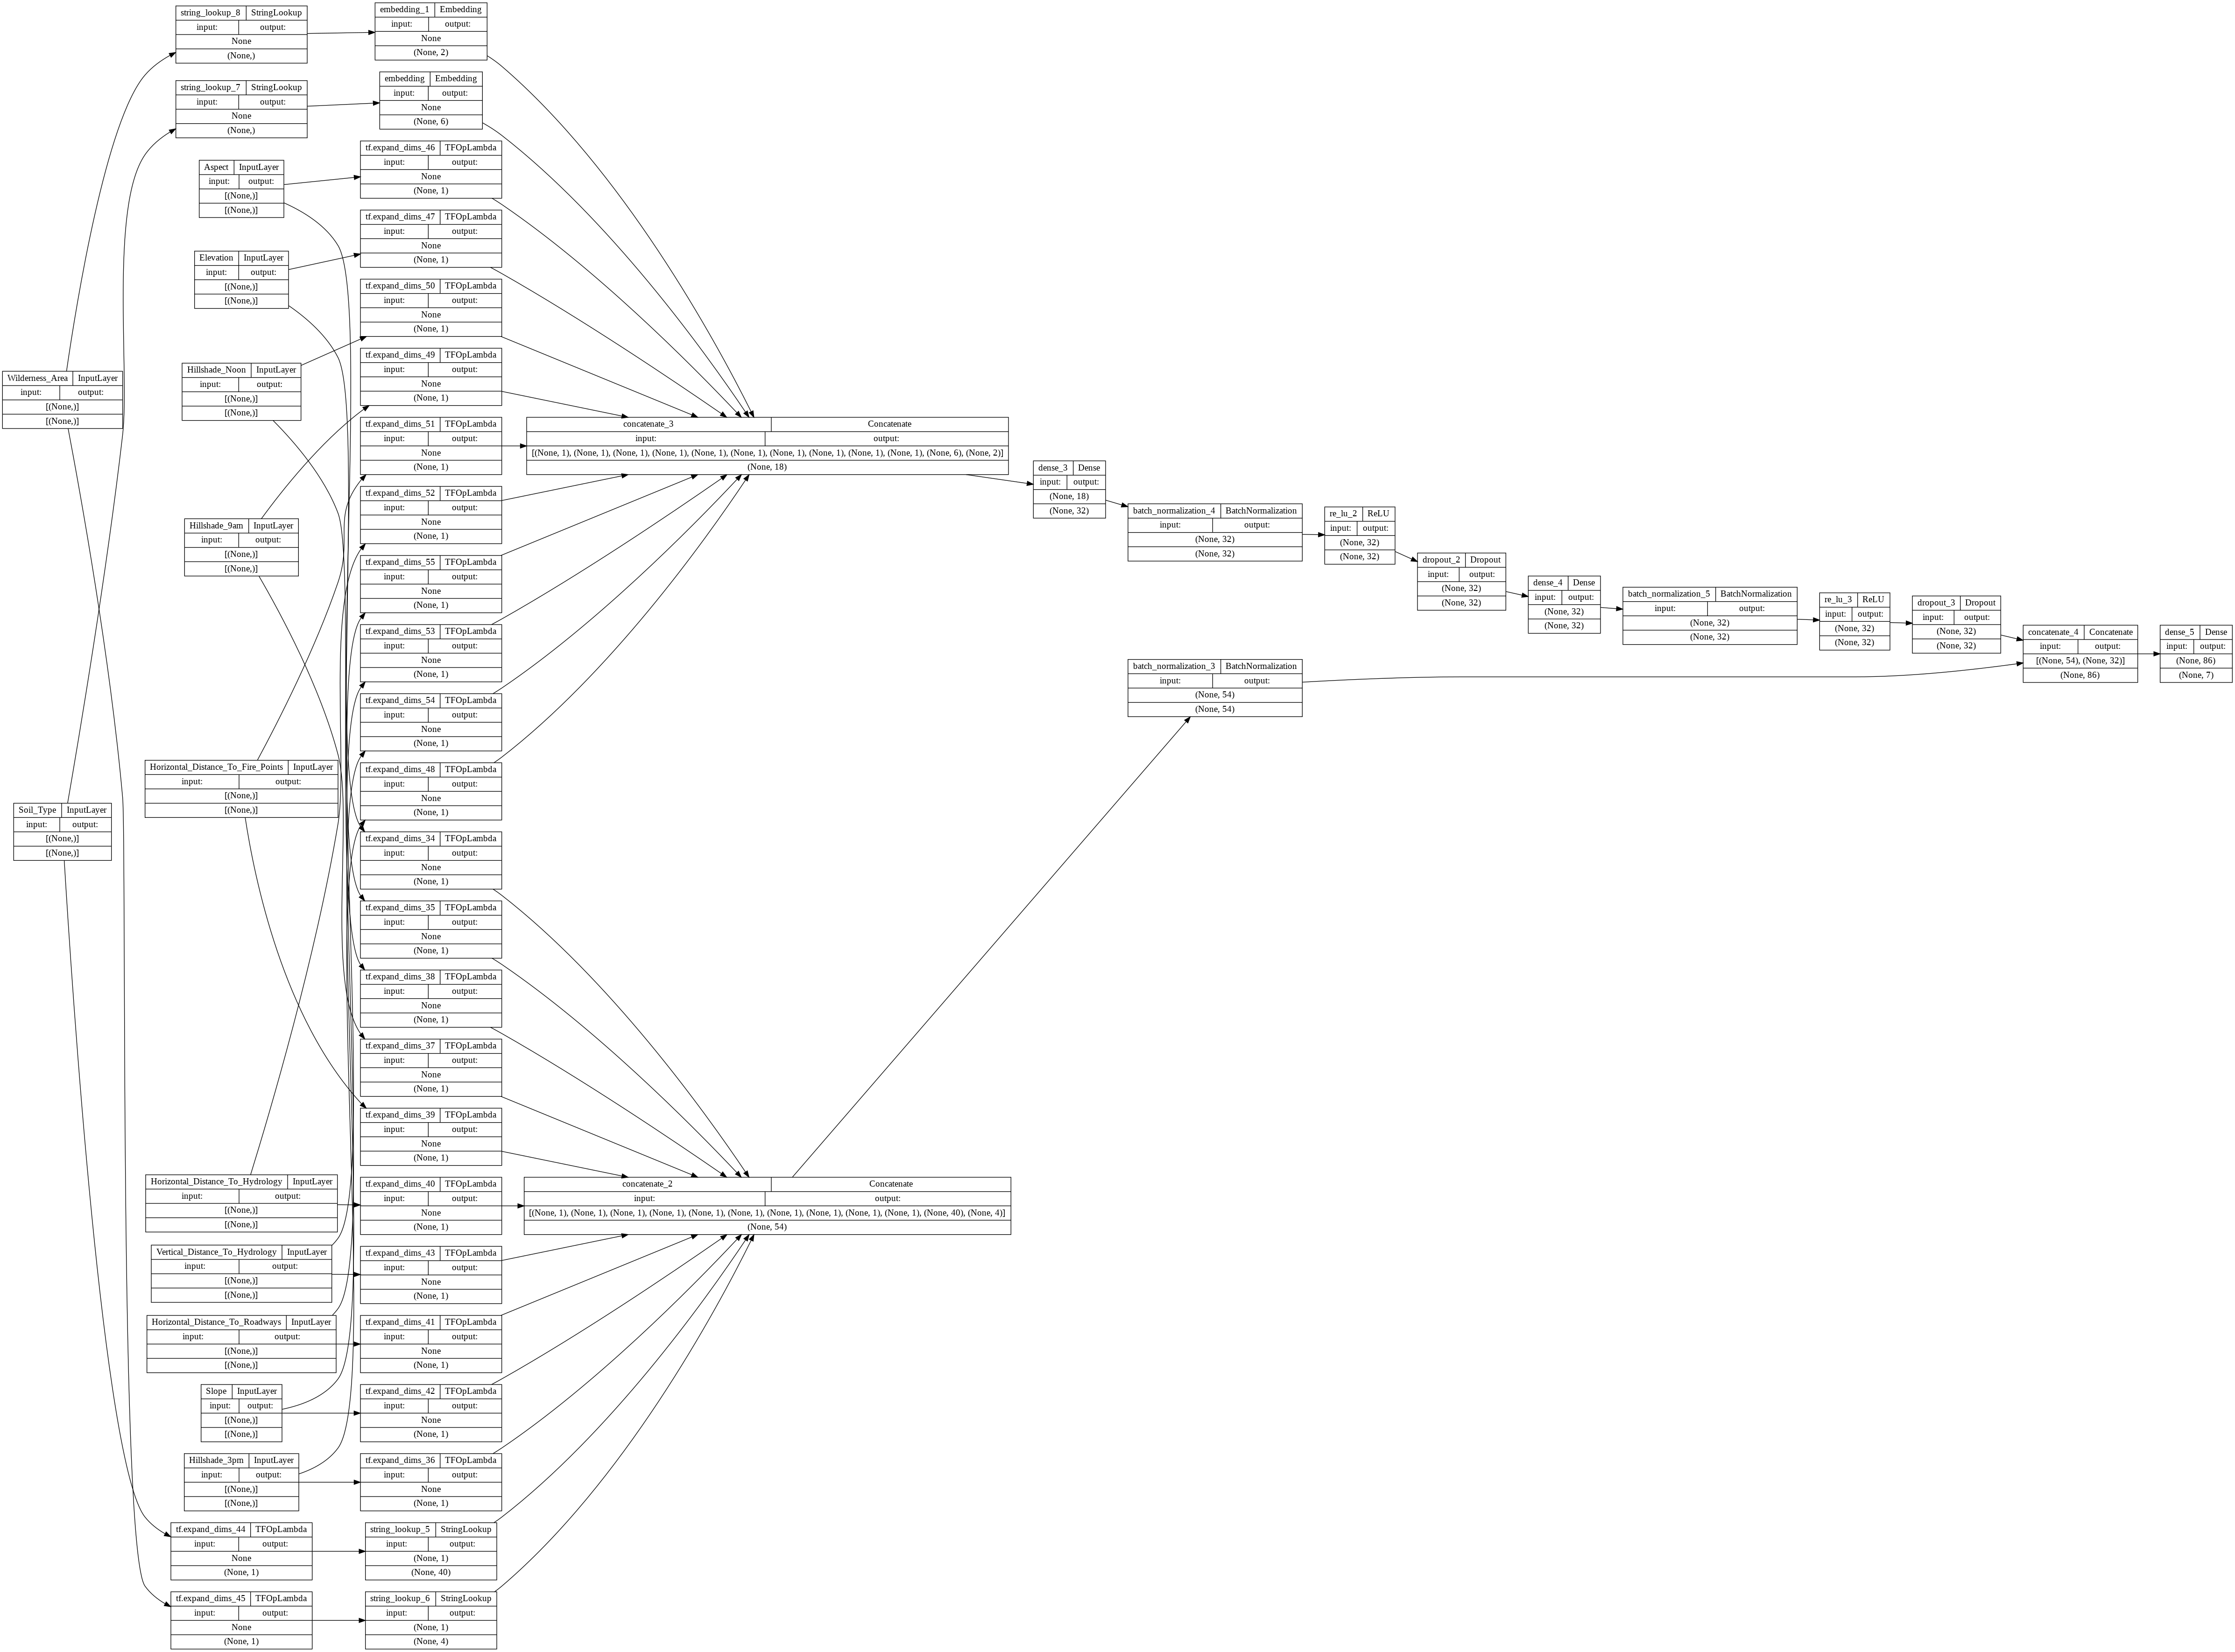

In [20]:
import math 


def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

In [21]:
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
1863/1863 [==============================] - 18s 9ms/step - loss: 0.7052 - sparse_categorical_accuracy: 0.7070
Epoch 2/50
1863/1863 [==============================] - 13s 7ms/step - loss: 0.6048 - sparse_categorical_accuracy: 0.7369
Epoch 3/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5858 - sparse_categorical_accuracy: 0.7448
Epoch 4/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5740 - sparse_categorical_accuracy: 0.7500
Epoch 5/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5649 - sparse_categorical_accuracy: 0.7540
Epoch 6/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5580 - sparse_categorical_accuracy: 0.7577
Epoch 7/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5508 - sparse_categorical_accuracy: 0.7608
Epoch 8/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5464 - sparse_categorical_accuracy: 0.7

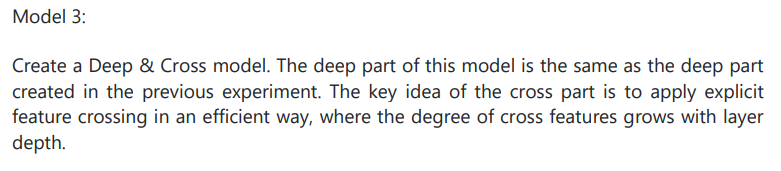

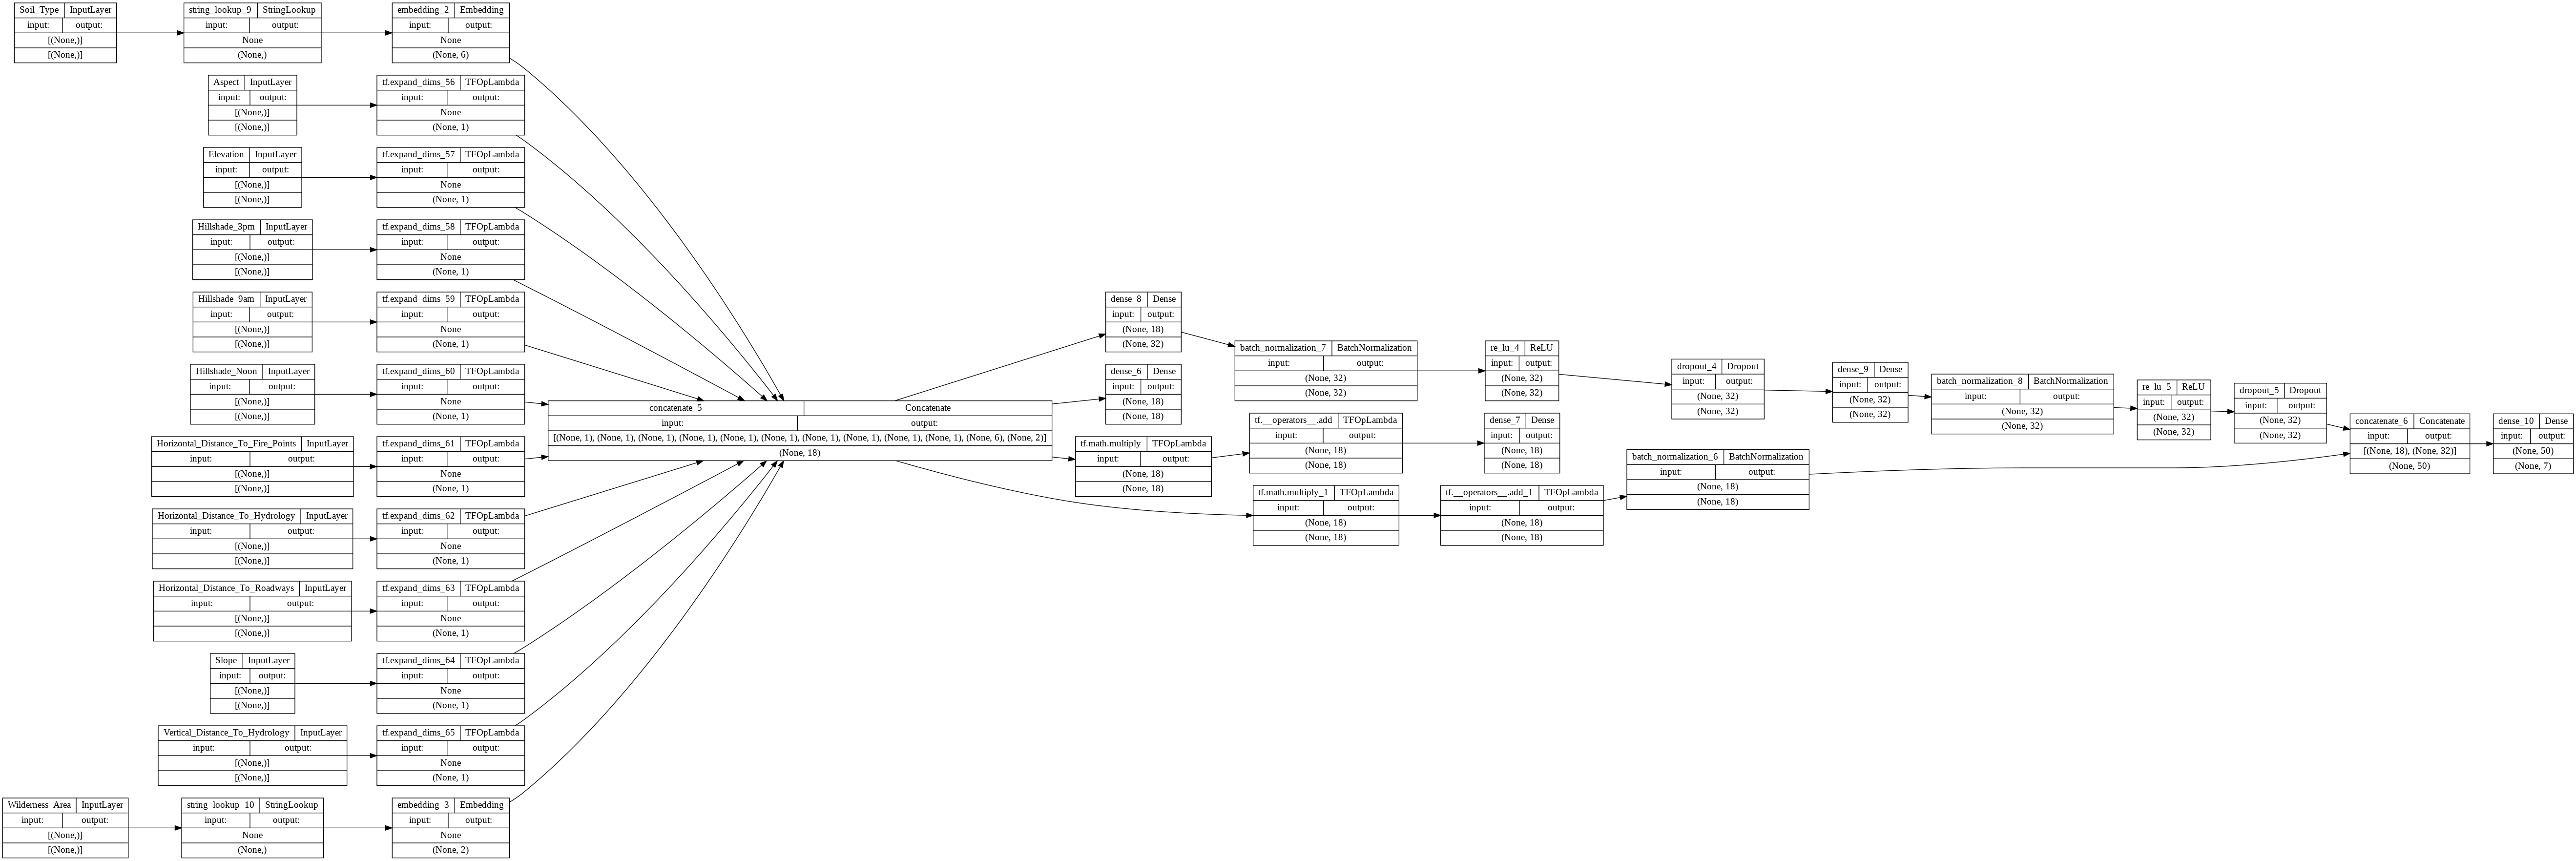

In [22]:
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

In [23]:
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
1863/1863 [==============================] - 17s 8ms/step - loss: 0.6917 - sparse_categorical_accuracy: 0.7133
Epoch 2/50
1863/1863 [==============================] - 11s 6ms/step - loss: 0.5887 - sparse_categorical_accuracy: 0.7481
Epoch 3/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5698 - sparse_categorical_accuracy: 0.7547
Epoch 4/50
1863/1863 [==============================] - 11s 6ms/step - loss: 0.5591 - sparse_categorical_accuracy: 0.7595
Epoch 5/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5513 - sparse_categorical_accuracy: 0.7626
Epoch 6/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5450 - sparse_categorical_accuracy: 0.7649
Epoch 7/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5404 - sparse_categorical_accuracy: 0.7668
Epoch 8/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5352 - sparse_categorical_accuracy: 0.7

## Observation for Accuracy
- Model-1 - Multi-layer feed-forward network : 70.33%
- Model-2 - Deep And Wide Network : 80.78%
- Model-3 - Deep and cross Network : 80.81% 